# Librerias o dependencias para manipular datos, visualizar y herramienta de optimización

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

# leer la hoja de excel

In [2]:
data = pd.read_excel("Datos para Problema de Optimización.xlsx")

# Limpiar y separar las tablas que se van a utilizar en el modelo

In [3]:

#separando las tablas respectivas de la hoja de excel.
demanda_de_cada_ciudad = data.iloc[1:8,1:7]
capacidad_de_produccion_de_cada_fabrica = data.iloc[12:18,1:7]
inventario_inicial = data.iloc[22:25,1:3]
costo_de_produccion = data.iloc[28:34,1:7]
costo_mensual_de_inventario = data.iloc[37:40,1:7]
costo_fijo_de_fabrica_tercerizada = data.iloc[43:47,1:7]
costo_de_transporte  = data.iloc[50:,1:]


# almacenando el nombre de las tablas para posterior uso.
tablas = ["demanda_de_cada_ciudad","capacidad_de_produccion_de_cada_fabrica",
          "inventario_inicial","costo_de_produccion","costo_mensual_de_inventario",
          "costo_fijo_de_fabrica_tercerizada","costo_de_transporte"]

#limpiando los vacios de cada una de las tablas y nombrando correctamente sus columnas.
for tabla in tablas:
    exec(f"{tabla}.columns = {tabla}.iloc[0]")
    exec(f"{tabla} = {tabla}.iloc[1:]")
    exec(f"d_cols = {tabla}.columns")
    exec(f"{tabla} = {tabla}.set_index(d_cols[0])")

# Transformación de los datos 
Pasar las filas a columnas y viceversa de la tabla costo de transporte, añadirle columna de Lima Terceros, luego cambiar el nombre de sus columnas para añadirles si son propias o de terceros, condersarlas en tres columnas que almacenen toda la info de
 origen, destino y costos de transporte; para finalmente unirla con la tabla de costos de produccion y hallar un costo total.


In [4]:

# Pasando las columnas a filas y viceversa, creo una columna nueva llamada Lima Terceros que representa
# la planta de terceros de lima,ordeno las columnas de la tabla en orden alfabetico, renombro las columnas 
# en base a los nombre respectivos de las plantas propias y de terceros, vuelo a transformar las filas en 
# columnas y viceversa, finalizando con un ordenamiento de los nombres y llenando el nombre de una columna
# vacia con el nombre index.
costo_de_transporte_T = costo_de_transporte.T
costo_de_transporte_T["Lima Terceros"] = costo_de_transporte_T["Lima"]
costo_de_transporte_T = costo_de_transporte_T[sorted(costo_de_transporte_T.columns)]
costo_de_transporte_T.columns = costo_de_produccion.sort_index().index
costo_de_transporte_2 = costo_de_transporte_T.T.reset_index()
costo_de_transporte_2.columns = costo_de_transporte_2.columns.fillna("index")

# Transformo la tabla condensando las combinaciones de fuente de produccion y destino de envio con su respectivo 
# coste de transporte,renombro las columnas resultantes a "Desde", "Hacia" y "costo de transporte", realizo una 
# union entre la tabla resultante con la tabla de costo de produccion en base a los puntos de produccion, despues 
# renombro la columna del costo de produccion, creo otra columna llamada costo total de entrega que es igual al costo 
# de transporte mas el costo de produccion y finalmente ordeno la tabla en orden alfabetico en base a los valores de la 
# columna Desde y Hacia.
produccion_optimizada = pd.melt(costo_de_transporte_2,id_vars=["index"],value_vars=costo_de_transporte_2.columns)
produccion_optimizada = produccion_optimizada.rename(columns={"index":"Desde",50:"Hacia","value":"costo de transporte"})
produccion_optimizada = produccion_optimizada.merge(costo_de_produccion.iloc[:,0],right_index=True,left_on="Desde",how="left")
produccion_optimizada = produccion_optimizada.rename(columns={produccion_optimizada.columns[-1]:"costo de produccion"})

produccion_optimizada["costo total de entrega"] = produccion_optimizada["costo de transporte"]+produccion_optimizada["costo de produccion"]
produccion_optimizada = produccion_optimizada.sort_values(["Desde","Hacia"])


# Copio la columna de produccion_optimizada para almacenar 
# costes totales alli sin alterar la otra tabla.
costo_total_de_produccion_sin_contar_almacen = produccion_optimizada.copy()

# Definición del modelo a través de las librerias de scipy 

$
\text{ - }{A}_{ub}\text{ representa los coeficientes de las inecuaciones que poseen las 30 variables posibles, }{b}_{ub}
\text{ son los valores a restringir las inecuaciones que representan la máxima capacidad de producción por ciudad.}
$

$
\text{ - }{A}_{eq}\text{ representa los coeficientes de las ecuaciones que poseen las 30 variables posibles, }{b}_{eq}
\text{ son los valores a restringir las ecuaciones que representan la máxima capacidad de producción por ciudad.}
$

$
\text{ - En la funcion objetivo el vector C representa el costo de envio mas el costo de producción de cada posible}
\text{combinacion de planta y destino la denominacion en este caso para cada uno de ellos es }{c}_{ij}\text{.}
$

$
A_{ub},b_{ub}\begin{equation}
\left\{ 
  \begin{aligned}
    \sum_{j=1}^{6}{x}_{1j}\leqslant 1080000,
    \sum_{j=1}^{6}{x}_{2j}\leqslant 350000\\
    \sum_{j=1}^{6}{x}_{3j}\leqslant 200000,
    \sum_{j=1}^{6}{x}_{4j}\leqslant 80000\\
    \sum_{j=1}^{6}{x}_{5j}\leqslant 10000,
    \forall{x}_{ij} \geqslant 0
  \end{aligned}
  \right.
\end{equation}
$
$
A_{eq},b_{eq}\begin{equation}
\left\{ 
  \begin{aligned}
    \sum_{i=1}^{5}{x}_{i1} = 729005,
    \sum_{i=1}^{5}{x}_{i2} = 236002\\
    \sum_{i=1}^{5}{x}_{i3} = 244038,
    \sum_{i=1}^{5}{x}_{i4} = 90655\\
    \sum_{i=1}^{5}{x}_{i5} = 178700.
    \sum_{i=1}^{5}{x}_{i6}=129726\\
    \forall{x}_{ij} \geqslant 0
  \end{aligned}
  \right.
\end{equation}
$

$
\text{Función Objetivo = } 
  \begin{aligned}
     \text{min ( }\sum_{i=1}^{5}\sum_{j=1}^{6}{x}_{ij}\times{c}_{ij}\text{ )}
  \end{aligned}
$


In [5]:
""" 
    Modelo que regresara la distribucion mas optima que minimiza
    el coste de produccion y transporte para cada mes que se le
    entrege descontando inventario.
"""
def programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(mes:int,df_b_ub,df_b_eq,df_c):
    
    # Creando la matriz de variables para las inecuaciones llamada A_ub
    # de 5x30 con todos los valores siendo 0.
    A_ub = np.full([5,30],0) 

    # Creando el vector condicionante de las inecuaciones llamado b_ub 
    # de 30 valores que son exactamente la maxima capacidad de produccion 
    # de un mes previamente seleccionado ordenado por la ciudad en la que
    # se encuentra la planta. 
    b_ub = df_b_ub.sort_index().iloc[:,mes].values
    
    # Creando la matriz de variables para las ecuaciones llamada A_eq
    # de 6x30 con todos los valores siendo 0.
    A_eq = np.full([6,30],0)

    # Cambiamos el valor de seis celdas de cada fila que representan
    # las variables a ser utilizadas para cada inecuacion las cuales 
    # son los 6 destinos posibles a los que cada planta puede enviar
    # su produccion. 
    for i in range(5):
        A_ub[i,6*i:6*i+6] =  1

    # Cambiamos el valor de cinco celdas de cada fila que representan
    # las variables a ser utilizadas para cada ecuacion de la matriz, 
    # las cuales son las 5 plantas que pueden abastecer la demanda de 
    # las  seis ciudades destino.
    for i in range(6):
        A_eq[i,5*i:5*i+5] = 1

    # Para que cada fila posea las variables que dependen en cada ecuacion
    # necesitamos hacer una transformacion de la matriz, por lo que pasaremos
    # las filas a columnas y vicerversa obteniendo una matriz de 30x6, para 
    # luego volver a cambiar la forma de la matriz a la que necesitamos 6x30
    # con lo que obtenemos el orden requerido para solucionar el problema.
    A_eq = A_eq.T.reshape(6,30)

    # Creando el vector condicionante de las ecuaciones llamado b_eq 
    # de 30 valores que son exactamente la demanda de un mes previamente
    #  seleccionado de las 6 ciudades ordenado por ciudad.  
    b_eq = df_b_eq.sort_index().iloc[:,mes].values
    
    # Creando la funcion objetivo c la cual es un producto de la cantidad de 
    # produccion destinada a cada ciudad desde cada planta con su respectivo 
    # coste de transporte mas coste de produccion que se mantiene constante en
    # cada mes.
    c = df_c["costo total de entrega"].values

    # Uso de la programacion lineal con el  metodo simplex para encontrar la
    # distribucion con el minimo coste de transporte y produccion.
    resultado = linprog(c=c,method="simplex",
                        A_eq=A_eq,b_eq=b_eq,
                        A_ub=A_ub,b_ub=b_ub,
                        bounds=(0,None))

    return resultado

# Añadiendo la interacción del almacén
- Diseño vectores que representen el almacén inicial y almacén final planiado.

In [6]:
# Cambio nombre de las columnas para poder manipularlas comodamente.
demanda_de_cada_ciudad.columns = ["enero","febrero","marzo","abril","mayo"]
capacidad_de_produccion_de_cada_fabrica.columns = ["enero","febrero","marzo","abril","mayo"]

In [7]:
"""
    Configuracion del almacen retorna el almacen inicial, almacen final y 
    demanda de cada ciudad de descontando inventario.
"""
def configuracion_de_almacenes(opcion,df):
    
    # Creacion de las tablas de almacen inicial y final poseen como indices
    # los indices de la demanda de cada ciudad.
    almacen_inicial = pd.DataFrame(index=df.index)
    almacen_final = pd.DataFrame(index=df.index)
    
    # Ingreso de datos del almacen inicial en Enero el cual nos dan de dato
    # el primer valor representa el almacen en Lima y el segundo en Arequipa
    # el resto van de relleno para poder operar entre tablas.
    almacen_inicial["enero"] = np.array([40000,60000,0,0,0,0])
    
    # Primera distribucion del almacen final, el cual tiene como diferencia
    # que se usa al maximo la capacidad de produccion en los meses en 
    # que la demanda es mayor a esta.
    if opcion == "A":
        almacen_final["enero"] = np.array([0,0,0,0,0,0])
        almacen_final["febrero"] = np.array([40000,52172,0,0,0,0])
        almacen_final["marzo"] = np.array([10000,20000,0,0,0,0])
        almacen_final["abril"] = np.array([40000,83513,0,0,0,0])
        almacen_final["mayo"] = np.array([0,0,0,0,0,0])
    
    # En la segunda opcion se usa el almacen final, de tal forma que la produccion 
    # nunca alcance su maxima capacidad lo cual modifica ligeramente las rutas con 
    # las que se distribuira la produccion.
    elif opcion == "B":        
        almacen_final["enero"] = np.array([0,0,0,0,0,0])
        almacen_final["febrero"] = np.array([4e+4,6e+4,0,0,0,0])
        almacen_final["marzo"] = np.array([1e+4,2e+4,0,0,0,0])
        almacen_final["abril"] = np.array([4e+4,8.4e+4,0,0,0,0])
        almacen_final["mayo"] = np.array([0,0,0,0,0,0])

    # EL almacen inicial es igual al almacen final del mes anterior.
    almacen_inicial["febrero"] = almacen_final["enero"]
    almacen_inicial["marzo"] = almacen_final["febrero"]
    almacen_inicial["abril"] = almacen_final["marzo"]
    almacen_inicial["mayo"] = almacen_final["abril"]
    
    # Copio la tabla para no alterar la tabla origen.
    demanda_de_cada_ciudad_contando_inventario = df.copy()

    # Adhiero y sustraigo el almacen inicial y final a la tabla copiada.
    demanda_de_cada_ciudad_contando_inventario = demanda_de_cada_ciudad_contando_inventario - almacen_inicial
    demanda_de_cada_ciudad_contando_inventario = demanda_de_cada_ciudad_contando_inventario + almacen_final
    
    return almacen_inicial,almacen_final,demanda_de_cada_ciudad_contando_inventario

In [8]:
# Ejecutando la configuracion de almacenes en la tabla demanda de cada ciudad.
almacen_inicial,almacen_final,demanda_de_cada_ciudad_contando_inventario = configuracion_de_almacenes(opcion="A",df=demanda_de_cada_ciudad)

# Copiando tablas que se usaran para optimizar la distribucion para no alterar sus valores.
df_b_ub = capacidad_de_produccion_de_cada_fabrica.copy()
df_b_eq = demanda_de_cada_ciudad_contando_inventario.copy()
df_c = produccion_optimizada.copy()

# Ejecutando la funcion que optimiza las distribuciones de cada mes con sus respectivas 
# demandas modificadas por el alamcen planeado para cada mes.
resultado_enero = programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(0,df_b_ub=df_b_ub,df_b_eq=df_b_eq,df_c=df_c)
resultado_febrero = programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(1,df_b_ub=df_b_ub,df_b_eq=df_b_eq,df_c=df_c)
resultado_marzo = programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(2,df_b_ub=df_b_ub,df_b_eq=df_b_eq,df_c=df_c)
resultado_abril = programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(3,df_b_ub=df_b_ub,df_b_eq=df_b_eq,df_c=df_c)
resultado_mayo = programacion_lineal_para_optimizar_los_costes_de_produccion_y_transporte(4,df_b_ub=df_b_ub,df_b_eq=df_b_eq,df_c=df_c)

# Midiendo la capacidad de producción y contratación de terceros
- El objetivo es observar si ambas son capaces de avastecer la demanda en base al inventario planeado.
- Esto ocurre cuando todas las diferencias de la producción con la demanda son positivas.

In [9]:
# Observar si la modificacion del almacen despues de ser añadido a la demanda, permite que la capacidad de produccion 
# sea positiva lo cual significa que puede abastecerse en todos los meses.
capacidad_de_produccion_de_cada_fabrica.sum()-demanda_de_cada_ciudad_contando_inventario.sum()

enero      201874
febrero     81701
marzo           0
abril         516
mayo            0
dtype: object

# Observando si la optimización ha sido correcta en todos los meses

In [10]:
# Nos permite ver si todos los procesos de optmizacion se ejecutaron
# correctamente.
[resultado_enero.message,
 resultado_febrero.message,
 resultado_marzo.message,
 resultado_abril.message,
 resultado_mayo.message]

['Optimization terminated successfully.',
 'Optimization terminated successfully.',
 'Optimization terminated successfully.',
 'Optimization terminated successfully.',
 'Optimization terminated successfully.']

# Resultado de la producción optimizada por el modelo

In [11]:
# Añadimos el vector resultante de la optmizacion para cada mes de la distribucion. 
produccion_optimizada["produccion enero 2023"] = resultado_enero.x
produccion_optimizada["produccion febrero 2023"] = resultado_febrero.x
produccion_optimizada["produccion marzo 2023"] = resultado_marzo.x
produccion_optimizada["produccion abril 2023"] = resultado_abril.x
produccion_optimizada["produccion mayo 2023"] = resultado_mayo.x

In [12]:
# Separamos la columna de los costes de produccion mas los coste de transporte para agilizar
# las operaciones de este vector con el resultado correspondiente.
columna_de_costos = costo_total_de_produccion_sin_contar_almacen["costo total de entrega"].copy().values

# Calculo del coste de produccion y transporte de cada mes distrbuido optimizado. 
costo_total_de_produccion_sin_contar_almacen["costo de distribucion y produccion enero 2023"] = resultado_enero.x*columna_de_costos
costo_total_de_produccion_sin_contar_almacen["costo de distribucion y produccion febrero 2023"] = resultado_febrero.x*columna_de_costos
costo_total_de_produccion_sin_contar_almacen["costo de distribucion y produccion marzo 2023"] = resultado_marzo.x*columna_de_costos
costo_total_de_produccion_sin_contar_almacen["costo de distribucion y produccion abril 2023"] = resultado_abril.x*columna_de_costos
costo_total_de_produccion_sin_contar_almacen["costo de distribucion y produccion mayo 2023"] = resultado_mayo.x*columna_de_costos

In [13]:
# Tabla de las producciones resultantes en cada mes
produccion_optimizada.iloc[:,-5:].sum()

produccion enero 2023      1518126.0
produccion febrero 2023    1638299.0
produccion marzo 2023      1720000.0
produccion abril 2023      1999484.0
produccion mayo 2023       2000000.0
dtype: float64

# Proceso de salida
- Creacion de una tabla que agrupe lo siguiente:
   - Inventario Inicial
   - Produccion
   - Envios
   - Inventario Final
- El proceso cubre todos los meses de produccion y puede ser facilmente configurado para observar otras variables de interes como el costo de produccion, costo de envios y costo de almacenamiento.

In [14]:
# Creacion de la tabla  de resultados el cual resume todos los datos 
# importantes en cada mes.
tabla_de_resultados = pd.DataFrame(index=["enero","febrero","marzo","abril","mayo"])

# Sumamos los valores del inventario inicial y final para cada mes.
tabla_de_resultados["inventario inicial"] = almacen_inicial.sum()
tabla_de_resultados["inventario final"] = almacen_final.sum()

# Sumamos los valores de la produccion para cada mes.
tabla_de_resultados["produccion"] = produccion_optimizada.iloc[:,-5:].sum().values

# Sumamos el valor del inventario inicial con la produccion y le 
# restamos el inventario final para calcular los envios.
tabla_de_resultados["envios"] = tabla_de_resultados[["inventario inicial","produccion"]].sum(axis=1)-tabla_de_resultados["inventario final"]

# Ordenamos la disposicion de las columnas y luego cambios de posicion
# las filas con las columnas para obtener la tabla final.
tabla_de_resultados = tabla_de_resultados[["inventario inicial","produccion","envios","inventario final"]]
tabla_de_resultados = tabla_de_resultados.T

tabla_de_resultados

,enero,febrero,marzo,abril,mayo
inventario inicial,100000.0,0.0,92172.0,30000.0,123513.0
produccion,1518126.0,1638299.0,1720000.0,1999484.0,2000000.0
envios,1618126.0,1546127.0,1782172.0,1905971.0,2123513.0
inventario final,0.0,92172.0,30000.0,123513.0,0.0


# Costo de almacenamiento

In [15]:
# Creamos una tabla de costos del almacenamiento que cuenten las otras cuatro
# ciudades destino para poder operar con las otras tablas.
cc = np.array([[.08,.08,.08,.08,.08],[.06,.06,.06,.06,.06],
          [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])

# Multiplicamos la tabla anterior con la de almacen inicial para obtener el coste
# de almacenar determinada cantidad de almacen en cada ciudad durante cada mes.
cc = cc*almacen_inicial

In [16]:
cc

,enero,febrero,marzo,abril,mayo
NaT,,,,,
Lima,3200.0,0.0,3200.00,800.0,3200.00
Arequipa,3600.0,0.0,3130.32,1200.0,5010.78
Cusco,0.0,0.0,0.00,0.0,0.00
Trujillo,0.0,0.0,0.00,0.0,0.00
Huancayo,0.0,0.0,0.00,0.0,0.00
Piura,0.0,0.0,0.00,0.0,0.00


In [17]:
# Ponemos en orden alfabetico la tabla en base a las ciudades.  
cc = cc.sort_index()

# Visualizar el resultado del proceso

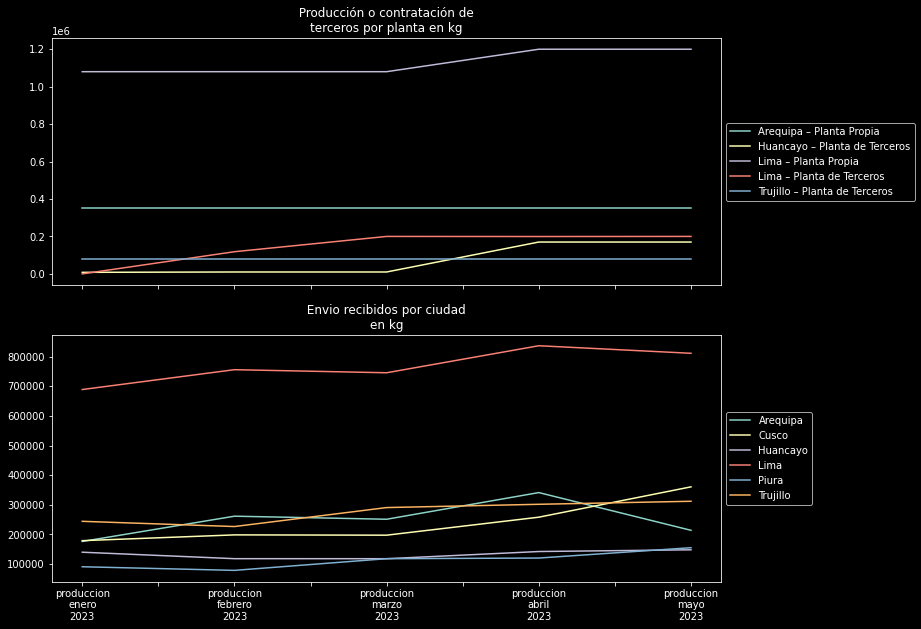

In [95]:
# Modificar el estilo de los ploteos
plt.style.use("dark_background")

fig,(ax,ax_1) = plt.subplots(nrows=2,sharex=True,figsize=(12,10))

# Agrupamos los valores de la distribucion en base a la planta de produccion fuente
# sin contar almacenamiento y sumamos el total de produccion que se genero ahi para 
# luego visualizarlo con una barra horizontal.
df_1 = produccion_optimizada.groupby(["Desde"]).sum()
df_1 = df_1.T
df_1.index = df_1.index.map(lambda x: x.replace(" –","").replace(" ","\n"))
df_1.plot(kind="line",ax=ax,rot=0,title=" Producción o contratación de \nterceros por planta en kg",legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Agrupamos los valores de la distribucion en base a la ciudad destino sin contar
# almacenamiento y sumamos el total de envios recibidos por mes.
df_2 = produccion_optimizada.groupby(["Hacia"]).sum()
df_2 = df_2.T
df_2.index = df_2.index.map(lambda x: x.replace(" –","").replace(" ","\n"))
df_2.plot(kind="line",ax=ax_1,title=" Envio recibidos por ciudad \nen kg",rot=0)
ax_1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

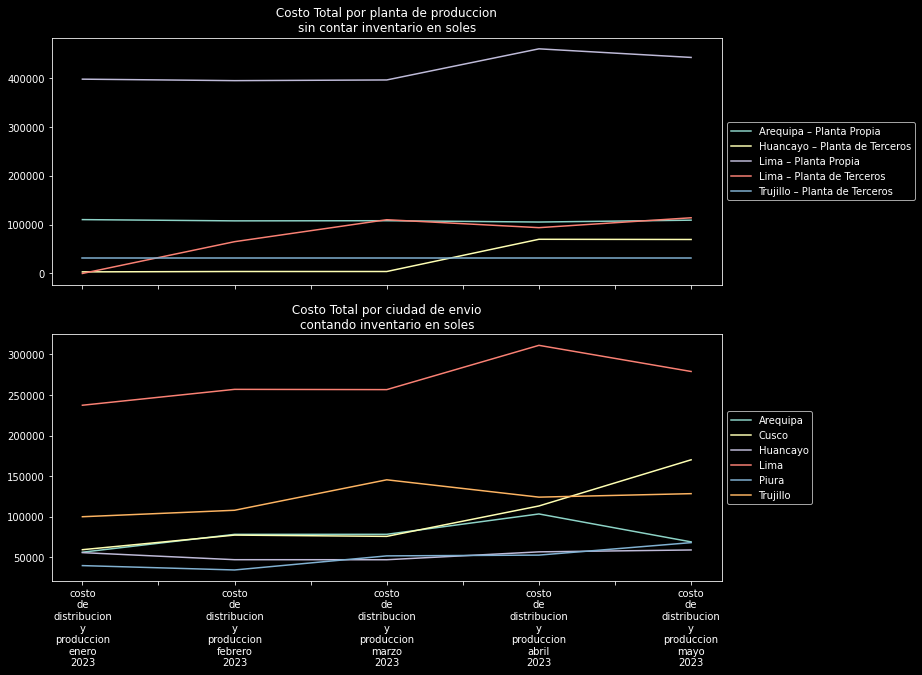

In [94]:
# Agrupamos los costes de la distribucion en base a la planta de produccion fuente
# contando almacenamiento y sumamos el total de produccion que se genero ahi para 
# luego visualizarlo con una barra horizontal.
df_3 = costo_total_de_produccion_sin_contar_almacen.groupby(["Desde"]).sum().iloc[:,-5:]
df_3 = df_3.T
df_3.index = df_3.index.map(lambda x: x.replace(" –","").replace(" ","\n"))

fig,(ax,ax_1) = plt.subplots(nrows=2,sharex=True,figsize=(12,10))

df_3.plot(kind="line",ax=ax,rot=0,title=" Costo Total por planta de produccion \nsin contar inventario en soles",legend=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Agrupamos los costes de la distribucion en base a la ciudad destino contando
# almacenamiento y sumamos el total de envios recibidos por mes.
df_4 = (costo_total_de_produccion_sin_contar_almacen.groupby(["Hacia"]).sum().iloc[:,-5:]+cc.values)
df_4 = df_4.T
df_4.index = df_4.index.map(lambda x: x.replace(" –","").replace(" ","\n"))

df_4.plot(kind="line",ax=ax_1,
          title=" Costo Total por ciudad de envio \ncontando inventario en soles",
          rot=0)
ax_1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [20]:
(df_4.sum()).sum()

3343790.8100000005